# Generate polynomial features from minimal dataset

### Load minimal project dataset as `data_dict` and convert to numpy arrays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import re

HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Desktop', 'raw_data', 'ml')

with open('data/final_project_dataset.pkl', 'r') as data_file:
    data_dict = pickle.load(data_file)

del data_dict['TOTAL']
del data_dict['LOCKHART EUGENE E'] # has only NaN values

In [2]:
all_keys = data_dict['METTS MARK'].keys()
all_keys.remove('email_address')
print 'Length of all_keys before moving poi', len(all_keys)
all_keys.insert(0, all_keys.pop(all_keys.index('poi')))
print 'Length of all_keys AFTER moving poi', len(all_keys)
print 'First item in all_keys: ', all_keys[0]

Length of all_keys before moving poi 20
Length of all_keys AFTER moving poi 20
First item in all_keys:  poi


In [3]:
from tools.feature_format import featureFormat

data = featureFormat(data_dict, all_keys, sort_keys=True, keep_keys=True, remove_NaN=False)
keys, labels, features = data[:,0],\
                         data[:,1].astype(float),\
                         data[:, 2:].astype(float)
print keys.shape, labels.shape, features.shape

(144,) (144,) (144, 19)


### Impute missing values using the mean of available feature data.

In [4]:
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='mean')
imp_features = imp.fit_transform(features)

### Add 2 and 3rd order polynomial interaction features

In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3, include_bias=False)
poly_features = poly.fit_transform(imp_features)
poly_names = np.array(poly.get_feature_names(all_keys[1:]))
poly_features.shape, poly_names.shape

((144, 1539), (1539,))

In [6]:
# Polynomials create some constant features with stdev == 0, 
# confirm that they are polynomials and remove them before feature selection
poly_std = np.std(poly_features, axis=0)
mask = np.where(poly_std == 0)
anti_mask = np.where(poly_std != 0)
print(poly_names[mask]), '\nlength: ', len(poly_names[mask])
mask_poly_features = poly_features[:, anti_mask[0]]
mask_poly_names = poly_names[anti_mask[0]]
print mask_poly_features.shape, mask_poly_names.shape

[] 
length:  0
(144, 1539) (1539,)


## Select the most distinct features

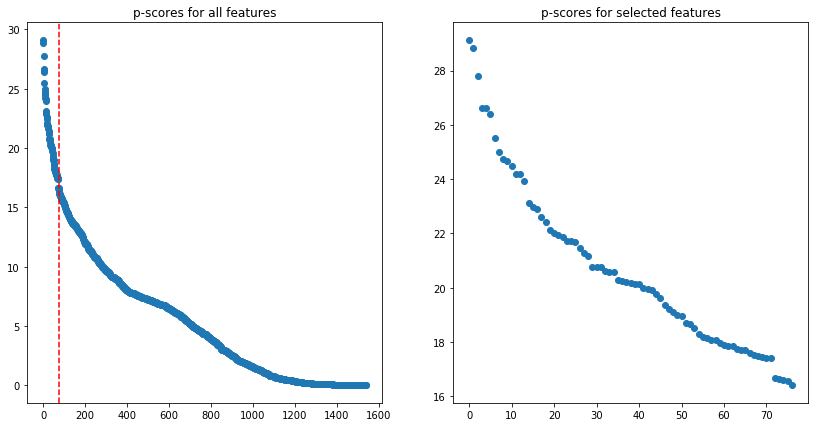

In [7]:
from sklearn.feature_selection import SelectPercentile, f_classif

percentile = 5

selector = SelectPercentile(f_classif, percentile=percentile)
selector.fit(mask_poly_features, labels)
scores = selector.scores_
sorted_scores = sorted(scores, reverse=True)
x = range(len(scores))
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121, title='p-scores for all features')
ax1.scatter(x, sorted_scores)
ax1.axvline(x=mask_poly_features.shape[1]*percentile/100, color='r', linestyle='--')

sel_mask = selector.get_support()
sel_masked_scores = scores[sel_mask]
sel_masked_scores = sorted(sel_masked_scores, reverse=True)
x = range(len(sel_masked_scores))
ax2 = fig.add_subplot(122, title='p-scores for selected features')
ax2.scatter(x, sel_masked_scores)
plt.show()

### Create a dictionary of the selected features

In [8]:
sel_features = selector.transform(mask_poly_features)
sel_poly_names = mask_poly_names[sel_mask]
print sel_features.shape, sel_poly_names.shape

(144, 77) (77,)


Add four names/emails introduced in [save_email_features](save_email_features.ipynb)

In [18]:
vector_only_names= np.array(['FORNEY M', 'DESPAIN TIM', 'LAWYER LARRY', 'RICHTER JEFF'])
all_keys = np.concatenate((keys, vector_only_names))
to_concat = np.zeros((4, sel_features.shape[1]))
to_concat.fill(np.nan)
sel_features_expanded = np.concatenate((sel_features, to_concat), axis=0)
print 'Expanded array shape:', sel_features_expanded.shape

Expanded array shape: (148, 77)


In [23]:
from sklearn.preprocessing import Imputer, RobustScaler

imp = Imputer(strategy='mean')
imp_sel_features_expanded = imp.fit_transform(sel_features_expanded)
scaler = RobustScaler()
final_features = scaler.fit_transform(imp_sel_features_expanded)

In [25]:
poly_data = {}
for ik, key in enumerate(all_keys):
    poly_data[key] = {}
    
    try:
        poly_data[key]['poi'] = data_dict[key]['poi']
    except KeyError:
        print key
        poly_data[key]['poi'] = True #All the new keys are pois
    
    for i, name in enumerate(sel_poly_names):
        poly_data[key][name] = float(final_features[ik, i])

FORNEY M
DESPAIN TIM
LAWYER LARRY
RICHTER JEFF


In [27]:
print 'poly_data length: ', len(poly_data),\
      ' compare with: ', len(data_dict) + 4
print 'inner keys length: ', len(poly_data['METTS MARK']),\
      ' compare with: ', len(sel_poly_names) + 1 # +1 for 'poi'

poly_data length:  148  compare with:  148
inner keys length:  78  compare with:  78


### Save new data as a dictionary: `poly_data.pkl` and a list of each person's keys:  `poly_names.pkl`

In [28]:
poly_path = os.path.join(DATA_PATH, 'poly_data.pkl')
with open(poly_path, 'wb') as f:
    pickle.dump(poly_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
sel_poly_names = list(sel_poly_names)
sel_poly_names.insert(0, 'poi')
keys_path = os.path.join(DATA_PATH, 'poly_names.pkl')
with open(keys_path, 'wb') as f:
    pickle.dump(sel_poly_names, f, protocol=pickle.HIGHEST_PROTOCOL)